In [19]:
import xgboost as xgb
import seaborn as sns
import numpy as np
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,6

In [21]:
dataset = pd.read_csv("C:\\Users\\user\\Downloads\\daily-minimum-temperatures-in-me.csv")

In [23]:
print(dataset.head(3))

       Date Daily minimum temperatures
0  1/1/1981                       20.7
1  1/2/1981                       17.9
2  1/3/1981                       18.8


In [25]:
print(dataset.tail(4))

            Date Daily minimum temperatures
3646  12/28/1990                       13.6
3647  12/29/1990                       13.5
3648  12/30/1990                       15.7
3649  12/31/1990                         13


In [27]:
dataset['Date'] = pd.to_datetime(dataset['Date'])

In [29]:
dataset.set_index('Date', inplace=True)

In [31]:
dataset.columns

Index(['Daily minimum temperatures'], dtype='object')

In [33]:
dataset.isna().sum()

Daily minimum temperatures    0
dtype: int64

In [35]:
dataset.dtypes

Daily minimum temperatures    object
dtype: object

In [37]:
# convert the Tempretures to values 
dataset['Daily minimum temperatures'] = dataset['Daily minimum temperatures'].str.strip()
# Handling the wrong format instances 
dataset['Daily minimum temperatures'] = dataset['Daily minimum temperatures'].replace(['', '?', 'nan'], np.nan)
dataset['Daily minimum temperatures'] = pd.to_numeric(dataset['Daily minimum temperatures'], errors='coerce')
dataset['Daily minimum temperatures'] = dataset['Daily minimum temperatures'].astype(float) # converting the values to float

In [39]:
print(dataset.dtypes)

Daily minimum temperatures    float64
dtype: object


In [43]:
dataset.head()

,Daily minimum temperatures
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


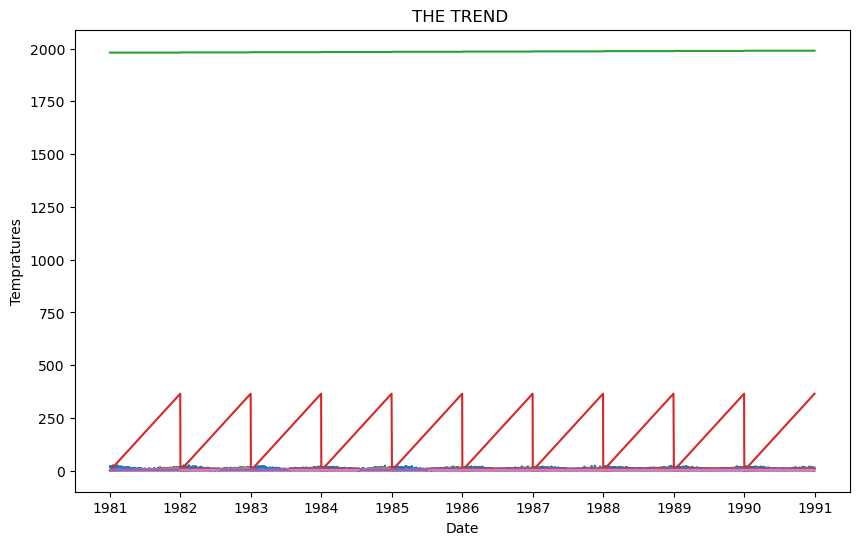

In [57]:
# CHECKING THE TREND IN THE DATASET
plt.xlabel("Date")
plt.ylabel("Tempratures")
plt.title("THE TREND ")
plt.plot(dataset)

In [49]:
def feature_generator(data):
    # Ensure the 'Date' column is in datetime format
    data = data.copy()  # Make a copy of the data to avoid changing the original dataset
    # Extract month, year, day of the year, and day of the week from the 'Date' column
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['Day_of_year'] = data.index.dayofyear
    data['Day_of_week'] = data.index.dayofweek
    return data

dataset = feature_generator(dataset)
print(dataset.head(4))

            Daily minimum temperatures  month  year  Day_of_year  Day_of_week
Date                                                                         
1981-01-01                        20.7      1  1981            1            3
1981-01-02                        17.9      1  1981            2            4
1981-01-03                        18.8      1  1981            3            5
1981-01-04                        14.6      1  1981            4            6


In [53]:
# Check for stationarity in the Dataset
# using the Rolling Statistics
dataset['Rolling_mean'] = dataset['Daily minimum temperatures'].rolling(window=365).mean()
dataset['std'] = dataset['Daily minimum temperatures'].rolling(window=365).std()

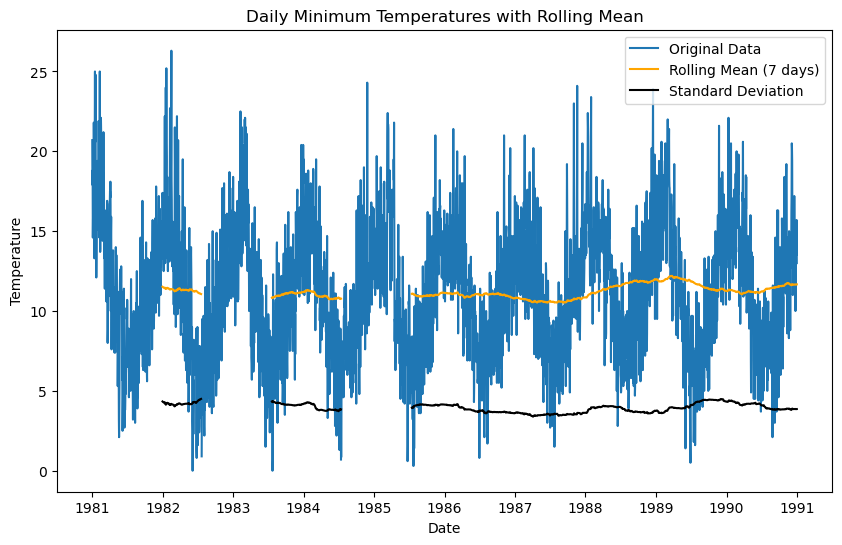

In [55]:
plt.figure(figsize=(10,6))
plt.plot(dataset['Daily minimum temperatures'], label='Original Data')
plt.plot(dataset['Rolling_mean'], label='Rolling Mean (7 days)', color='orange')
plt.plot(dataset['std'], label='Standard Deviation', color='black')
plt.title('Daily Minimum Temperatures with Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [59]:
# Using The ADFULLER TEST 
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(dataset['Daily minimum temperatures'].dropna())

In [61]:
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
print(f'Critical Values:')
for key, value in adf_test[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -4.444652847181709
p-value: 0.00024723724658534343
Critical Values:
   1%: -3.432154725699155
   5%: -2.8623374271161723
   10%: -2.567194482813802


In [ ]:
# MODEL BUILDING

In [89]:
dataset.isnull().sum()

Daily minimum temperatures       5
month                            2
year                             2
Day_of_year                      2
Day_of_week                      2
Rolling_mean                  1097
std                           1097
dtype: int64

In [99]:
dataset2 = pd.Series(dataset['Daily minimum temperatures'],index=dataset.index)
dataset2=dataset2.dropna()

In [182]:
train_dataset = dataset2.loc[dataset2.index < '1990-01-01']
test_dataset = dataset2.loc[dataset2.index >= '1990-01-01']
print(len(train_dataset),len(test_dataset))

3282 365


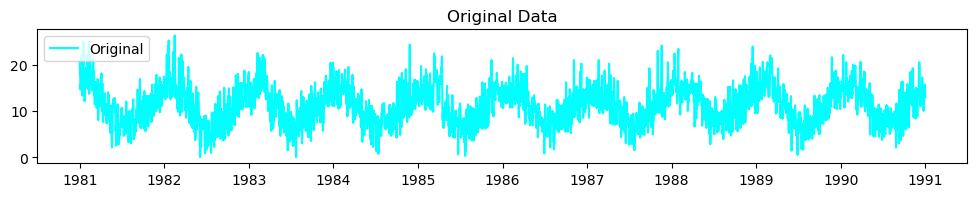

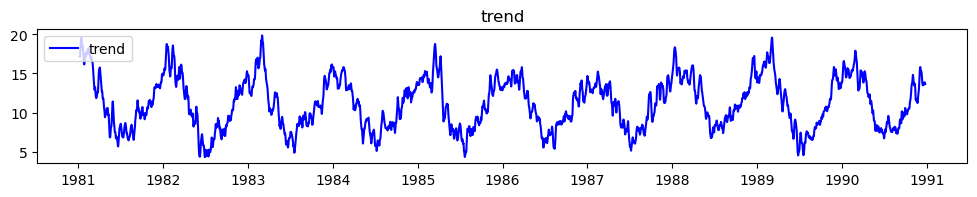

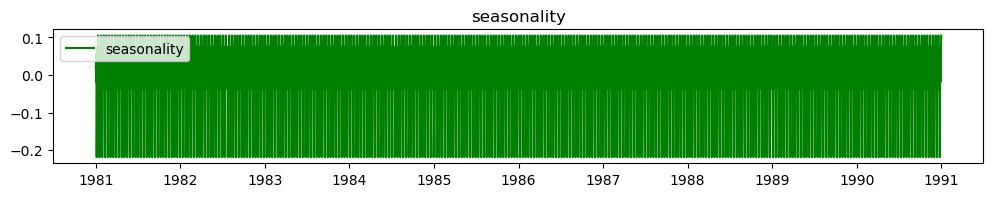

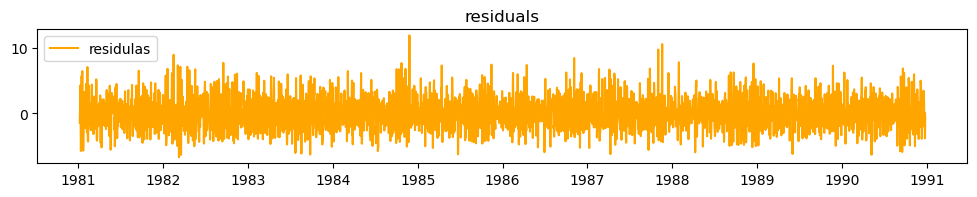

In [115]:
# Coomponents of Time series trend seasonality and residuals
from statsmodels.tsa.seasonal import seasonal_decompose #,seasonal_mean
decompose = seasonal_decompose(dataset2,period=12) 
trend = decompose.trend
seasonality = decompose.seasonal
residuals = decompose.resid

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(dataset2, label='Original', color='cyan')
plt.title('Original Data')
plt.legend(loc='upper left')


plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(trend, label='trend', color='blue')
plt.title('trend')
plt.legend(loc='upper left')


plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(seasonality, label='seasonality', color='green')
plt.title('seasonality')
plt.legend(loc='upper left')


plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(residuals, label='residulas', color='orange')
plt.title('residuals')
plt.legend(loc='upper left')

Text(0.5, 1.0, 'Q value')

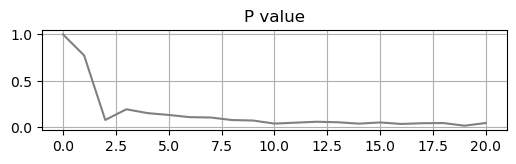

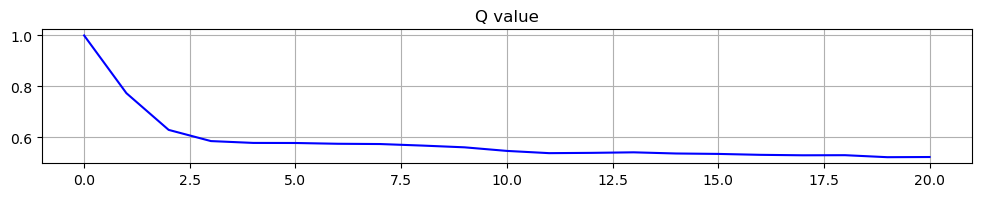

In [127]:
# calculate the values of p and q 
from statsmodels.tsa.stattools import pacf,acf # this will give as the values of p qnd q
p_pacf = pacf(dataset2,nlags=20,method='ols') 
q_acf = acf(dataset2,nlags=20)
plt.figure(figsize=(6,6))
plt.subplot(411)
plt.plot(p_pacf,color='gray')
plt.grid()
plt.title('P value')

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(q_acf,color='blue')
plt.grid()
plt.title('Q value')

In [184]:
# MODEL BUILDING 
model = ARIMA(train_dataset,order=(2,1,2))
results = model.fit()

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [169]:
print(results.summary())

                                   SARIMAX Results                                    
Dep. Variable:     Daily minimum temperatures   No. Observations:                 3647
Model:                         ARIMA(2, 1, 2)   Log Likelihood               -8378.010
Date:                        Mon, 30 Sep 2024   AIC                          16766.019
Time:                                18:54:44   BIC                          16797.026
Sample:                                     0   HQIC                         16777.062
                                       - 3647                                         
Covariance Type:                          opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4653      0.133      3.492      0.000       0.204       0.726
ar.L2         -0.1166      0.066     -1.755      0.079      -0.247 

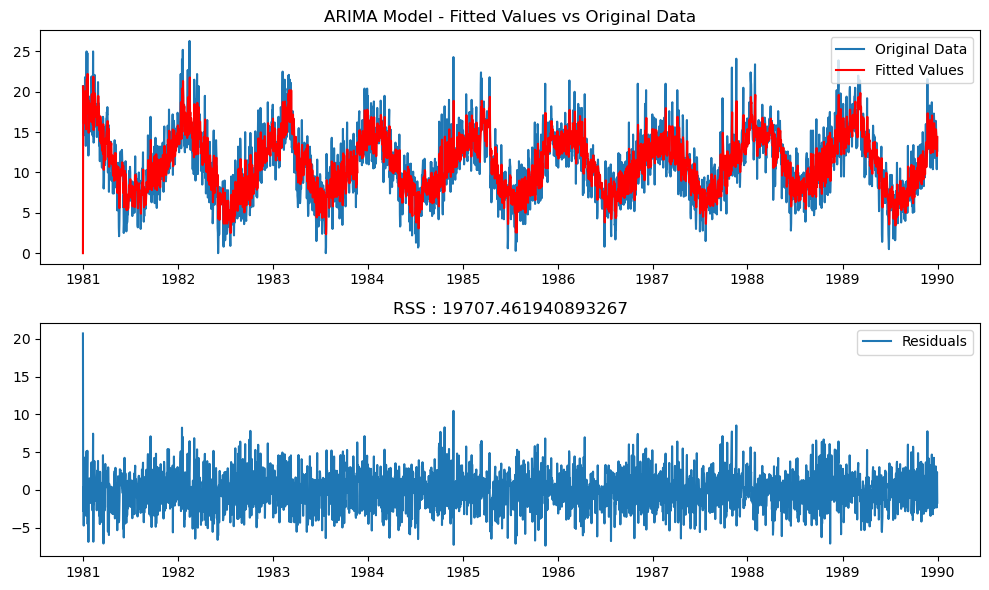

In [186]:
plt.subplot(211)
plt.plot(train_dataset, label='Original Data')
plt.plot(results.fittedvalues, color='red', label='Fitted Values')
plt.title('ARIMA Model - Fitted Values vs Original Data')
plt.legend()
# Plot residuals
plt.subplot(212)
plt.plot(results.resid, label='Residuals')
plt.title(f'RSS : {sum((results.resid)**2)}')
plt.legend()
plt.tight_layout()
plt.show()

In [192]:
# PREDICTING THE NEXT YEAR TEMPRATURES 
start = 365
end = start+len(train_dataset)
# The start should be the next point after the training data, and end  would represent the end of your prediction horizon

next_year = results.predict(start,end)

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [200]:
next_year

365     15.837170
366     15.467729
367     14.500733
368     13.912236
369     15.055372
          ...    
3643    13.358050
3644    13.358050
3645    13.358050
3646    13.358050
3647    13.358050
Name: predicted_mean, Length: 3283, dtype: float64